In [ ]:
pip install xgboost

In [ ]:
pip install holidays

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
from sklearn.metrics import mean_absolute_error as mae

import warnings
warnings.filterwarnings('ignore')


In [ ]:
data=pd.read_csv("/content/ola.csv")

In [ ]:
print('Shape of the data',data.shape)

Shape of the data (10886, 12)


In [ ]:
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [ ]:
print("Statistical Summary of data\n",data.describe().T)

Statistical Summary of data
               count        mean         std   min      25%      50%       75%  \
season      10886.0    2.506614    1.116174  1.00   2.0000    3.000    4.0000   
holiday     10886.0    0.028569    0.166599  0.00   0.0000    0.000    0.0000   
workingday  10886.0    0.680875    0.466159  0.00   0.0000    1.000    1.0000   
weather     10886.0    1.418427    0.633839  1.00   1.0000    1.000    2.0000   
temp        10886.0   20.230860    7.791590  0.82  13.9400   20.500   26.2400   
atemp       10886.0   23.655084    8.474601  0.76  16.6650   24.240   31.0600   
humidity    10886.0   61.886460   19.245033  0.00  47.0000   62.000   77.0000   
windspeed   10886.0   12.799395    8.164537  0.00   7.0015   12.998   16.9979   
casual      10886.0   36.021955   49.960477  0.00   4.0000   17.000   49.0000   
registered  10886.0  155.552177  151.039033  0.00  36.0000  118.000  222.0000   
count       10886.0  191.574132  181.144454  1.00  42.0000  145.000  284.0000   

In [ ]:
print('Casual + Registered = Count? ', ~(data.casual + data.registered - data['count']).any())

Casual + Registered = Count?  True


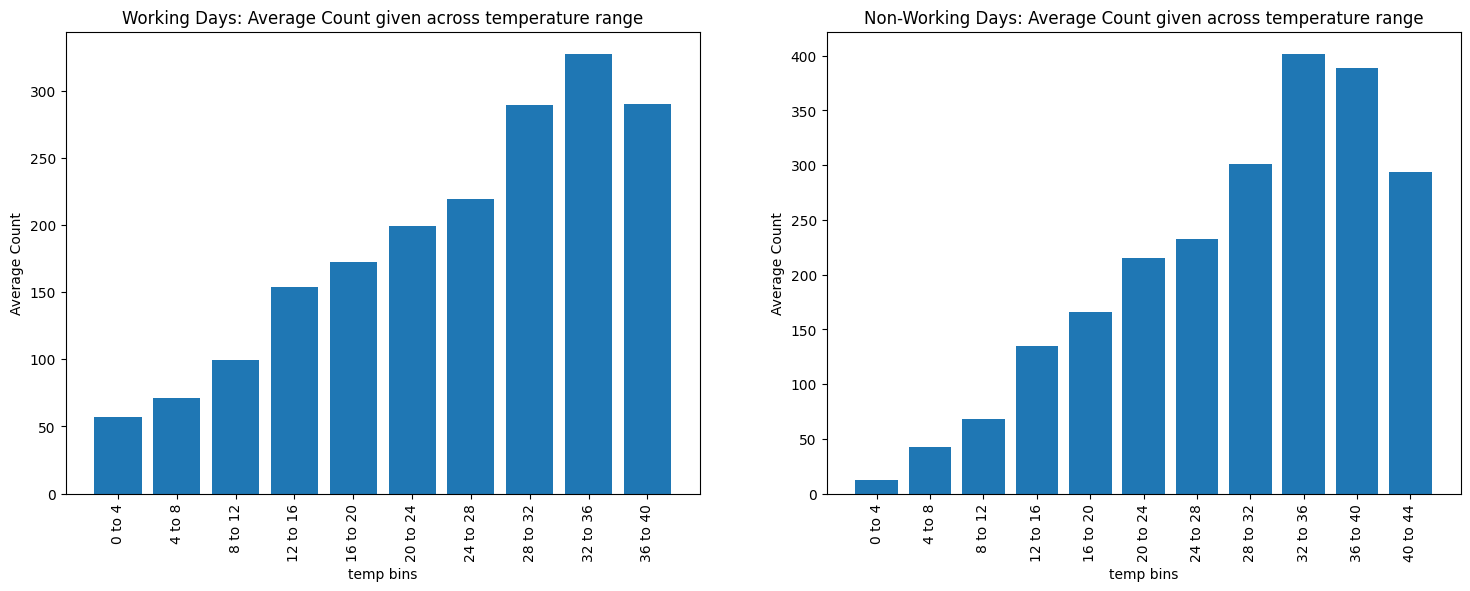

In [ ]:
bin_size = 4
data['temp_round'] = (data['temp'] // bin_size) * bin_size

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for i, working_day in enumerate([1, 0]):
    subset = data[data['workingday'] == working_day]
    mean_count_vs_temp = subset.groupby('temp_round')['count'].mean()
    idx = range(len(mean_count_vs_temp))
    labels = [f'{bin_size * i} to {bin_size * (i + 1)}' for i in range(len(mean_count_vs_temp))]

    axes[i].bar(x=idx, height=mean_count_vs_temp)
    axes[i].set_xticks(idx)
    axes[i].set_xticklabels(labels, rotation=90)
    axes[i].set_xlabel('temp bins')
    axes[i].set_ylabel('Average Count')
    axes[i].set_title(f'{"Working" if working_day else "Non-Working"} Days: Average Count given across temperature range')

plt.show()

FEATURE ENGINEERING

In [ ]:
#separated the date and time
parts = data["datetime"].str.split(" ", n=2, expand=True)
data["date"] = parts[0]
data["hour"] = parts[1].str[:2].astype('int')
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,temp_round,date,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,8.0,2011-01-01,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,8.0,2011-01-01,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,8.0,2011-01-01,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,8.0,2011-01-01,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,8.0,2011-01-01,4


In [ ]:
#extracting day, month, and year from the date column.
parts = data["date"].str.split("-", n=3, expand=True)
data["day"] = parts[2].astype('int')
data["month"] = parts[1].astype('int')
data["year"] = parts[0].astype('int')
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,temp_round,date,hour,day,month,year
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,8.0,2011-01-01,0,1,1,2011
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,8.0,2011-01-01,1,1,1,2011
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,8.0,2011-01-01,2,1,1,2011
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,8.0,2011-01-01,3,1,1,2011
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,8.0,2011-01-01,4,1,1,2011


In [ ]:
def weekend_or_weekday(year, month, day):
    d = datetime(year, month, day)
    if d.weekday() > 4:
        return 0
    else:
        return 1
data['weekday'] = data.apply(lambda x:
                         weekend_or_weekday(x['year'],
                                            x['month'],
                                            x['day']),
                         axis=1)
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,temp_round,date,hour,day,month,year,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,8.0,2011-01-01,0,1,1,2011,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,8.0,2011-01-01,1,1,1,2011,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,8.0,2011-01-01,2,1,1,2011,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,8.0,2011-01-01,3,1,1,2011,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,8.0,2011-01-01,4,1,1,2011,0


In [ ]:
def am_or_pm(x):
    if x > 11:
        return 1
    else:
        return 0
data['am_or_pm'] = data['hour'].apply(am_or_pm)
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,temp_round,date,hour,day,month,year,weekday,am_or_pm
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,8.0,2011-01-01,0,1,1,2011,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,8.0,2011-01-01,1,1,1,2011,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,8.0,2011-01-01,2,1,1,2011,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,8.0,2011-01-01,3,1,1,2011,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,8.0,2011-01-01,4,1,1,2011,0,0


In [ ]:
import holidays
def is_holiday(x):
    india_holidays = holidays.country_holidays('IN')
    if india_holidays.get(x):
        return 1
    else:
        return 0
data['holidays'] = data['date'].apply(is_holiday)
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,count,temp_round,date,hour,day,month,year,weekday,am_or_pm,holidays
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,...,16,8.0,2011-01-01,0,1,1,2011,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,...,40,8.0,2011-01-01,1,1,1,2011,0,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,...,32,8.0,2011-01-01,2,1,1,2011,0,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,...,13,8.0,2011-01-01,3,1,1,2011,0,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,...,1,8.0,2011-01-01,4,1,1,2011,0,0,0


Removing columns which are not useful

In [ ]:
data.drop(['datetime', 'date','atemp'],
        axis=1,
        inplace=True)

Exploratory Data Analysis

In [ ]:
data.isna().sum()

season        0
holiday       0
workingday    0
weather       0
temp          0
humidity      0
windspeed     0
casual        0
registered    0
count         0
temp_round    0
hour          0
day           0
month         0
year          0
weekday       0
am_or_pm      0
holidays      0
dtype: int64

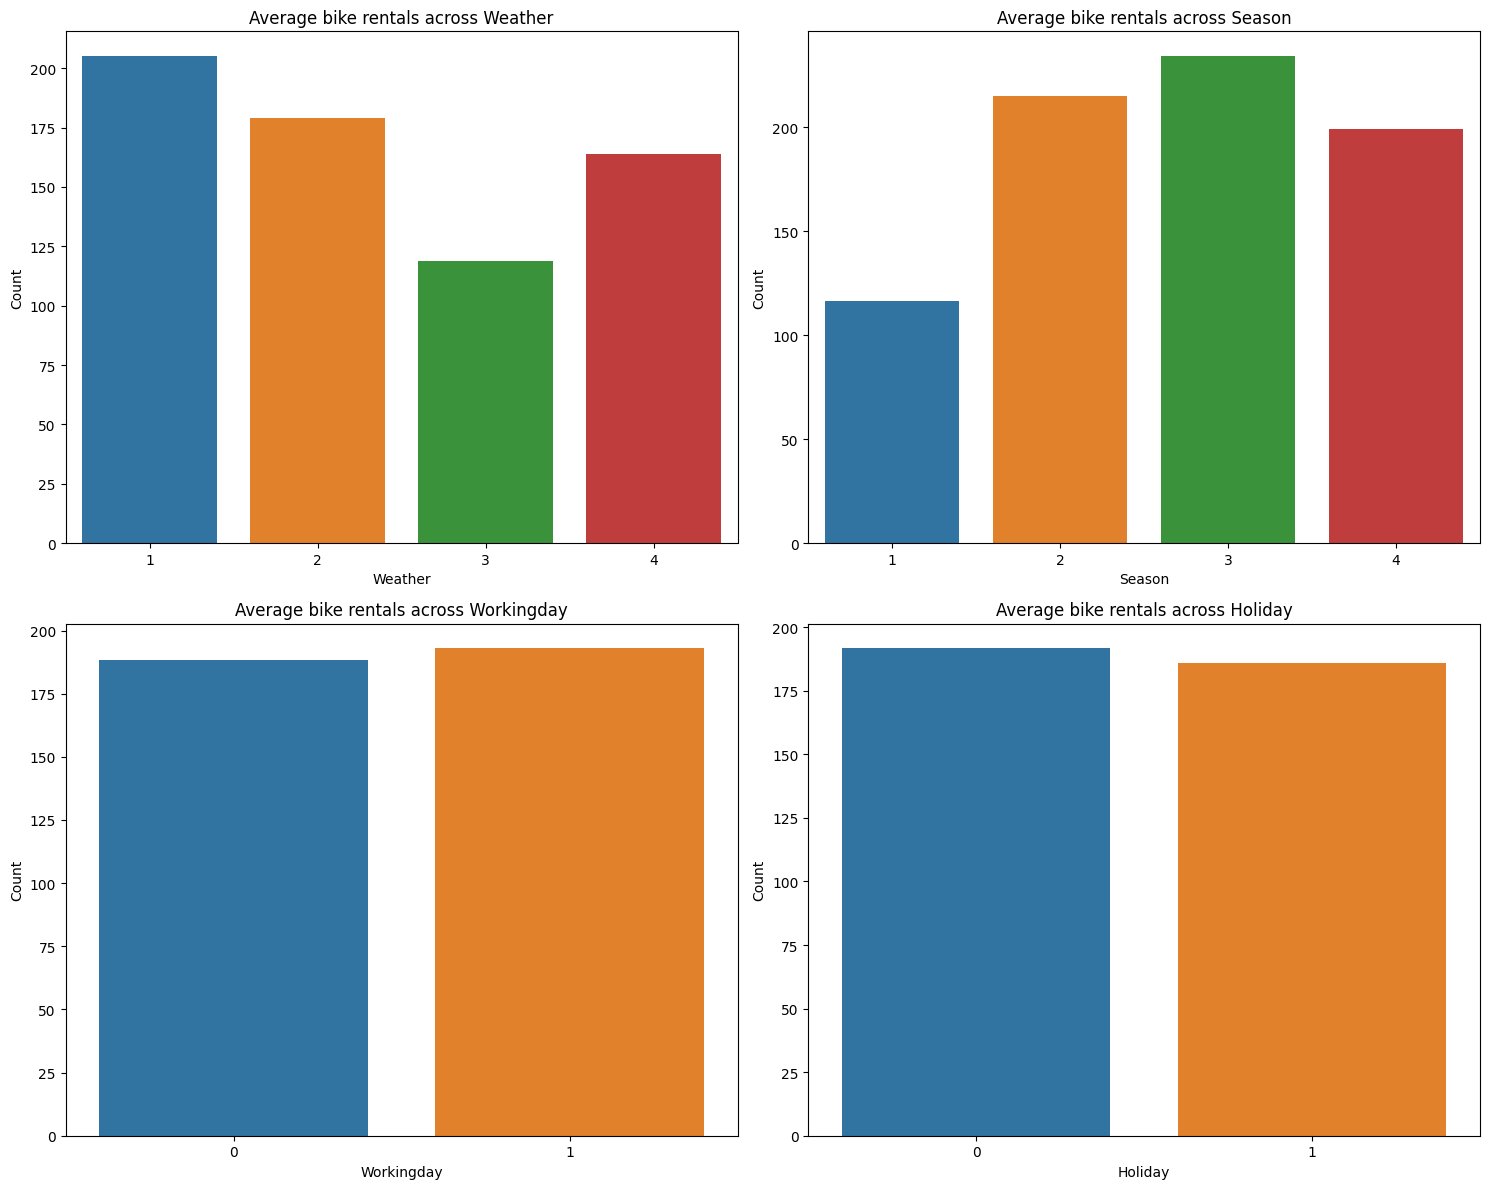

In [ ]:
categorical_columns = ['weather', 'season', 'workingday', 'holiday']
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

for i, col in enumerate(categorical_columns):
    group_data = data.groupby([col])['count'].mean().reset_index()

    sns.barplot(data=group_data, x=col, y='count', ax=axes[i // 2, i % 2])

    axes[i // 2, i % 2].set(xlabel=col.capitalize(), ylabel='Count', title=f'Average bike rentals across {col.capitalize()}')
plt.tight_layout()
plt.show()

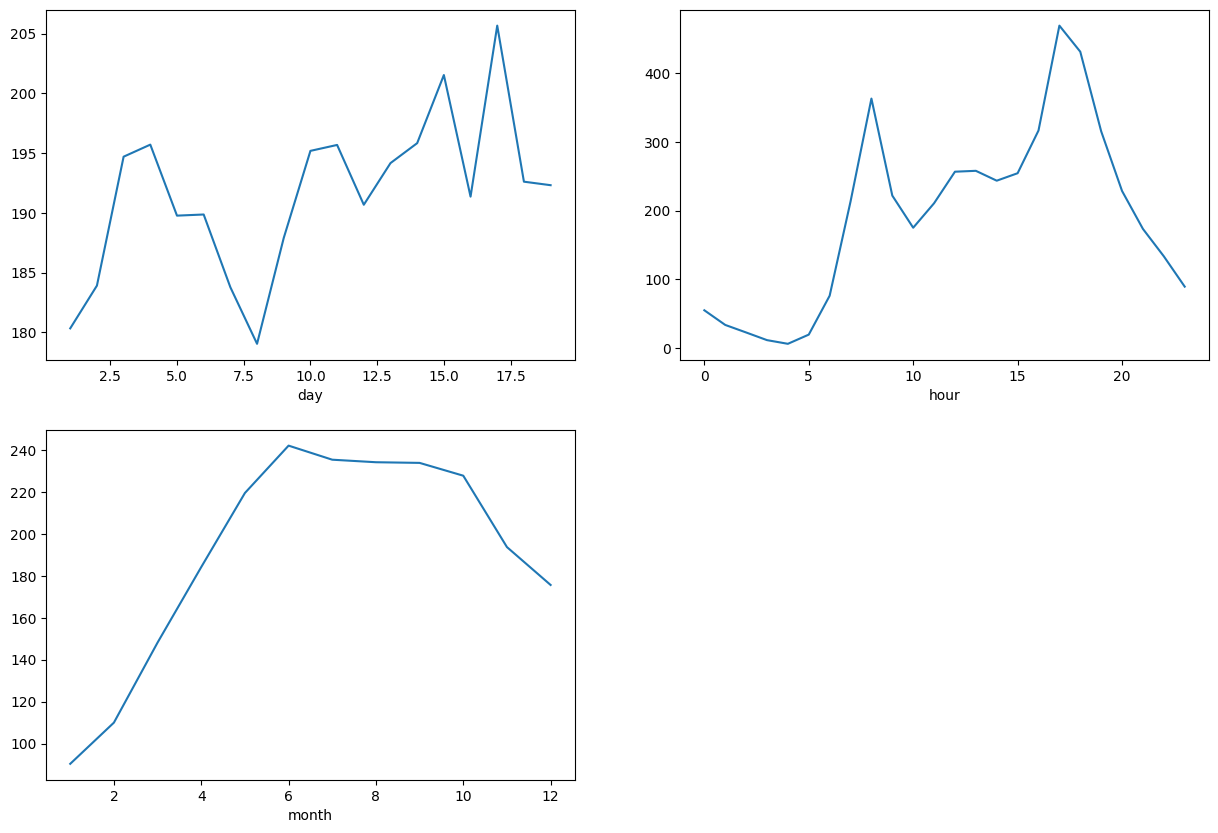

In [ ]:
features = ['day', 'hour', 'month']
plt.subplots(figsize=(15, 10))
for i, col in enumerate(features):
    plt.subplot(2, 2, i + 1)
    data.groupby(col).mean()['count'].plot()
plt.show()

OBSERVATIONS:

-There is no such pattern in the day-wise average of the ride requests.

-More ride requests in the working hours as compared to the non-working hours.

-The average ride request count has dropped in the month of festivals that is after the 7th month that is July that is due to more holidays in these months.

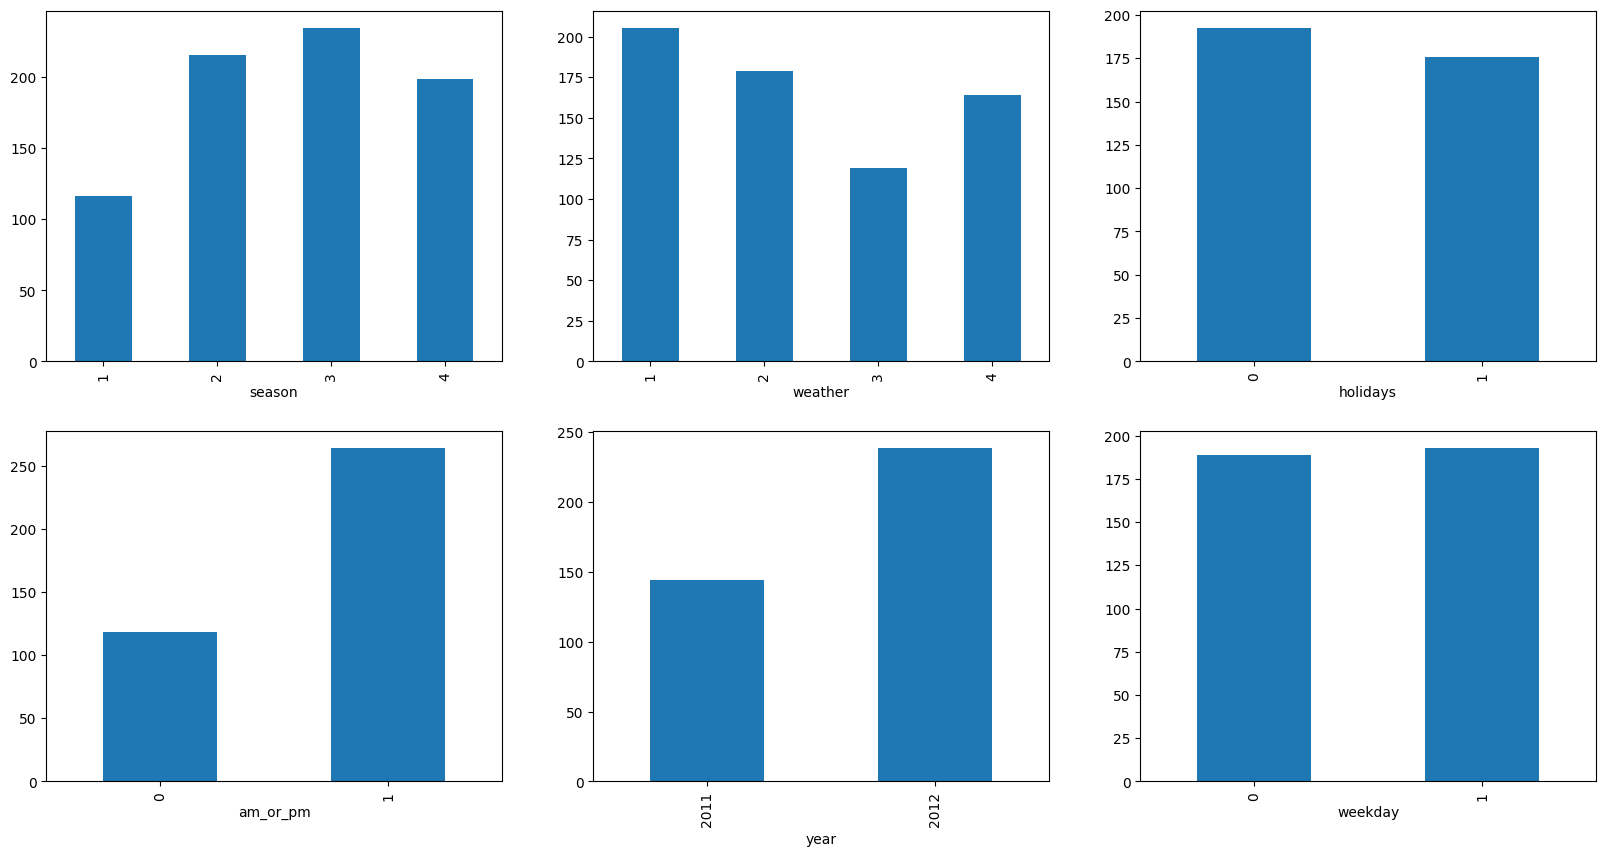

In [ ]:
features = ['season', 'weather', 'holidays','am_or_pm', 'year', 'weekday']
plt.subplots(figsize=(20, 10))
for i, col in enumerate(features):
    plt.subplot(2, 3, i + 1)
    data.groupby(col).mean()['count'].plot.bar()
plt.show()

OBSERVATIONS:

-Ride request demand is high in the summer as well as season.

-The third category was extreme weather conditions due to this people avoid taking bike rides and like to stay safe at home.

-More ride requests during working hours as compared to non-working hours.

-Bike ride requests have increased significantly from the year 2011 to the year 2012.

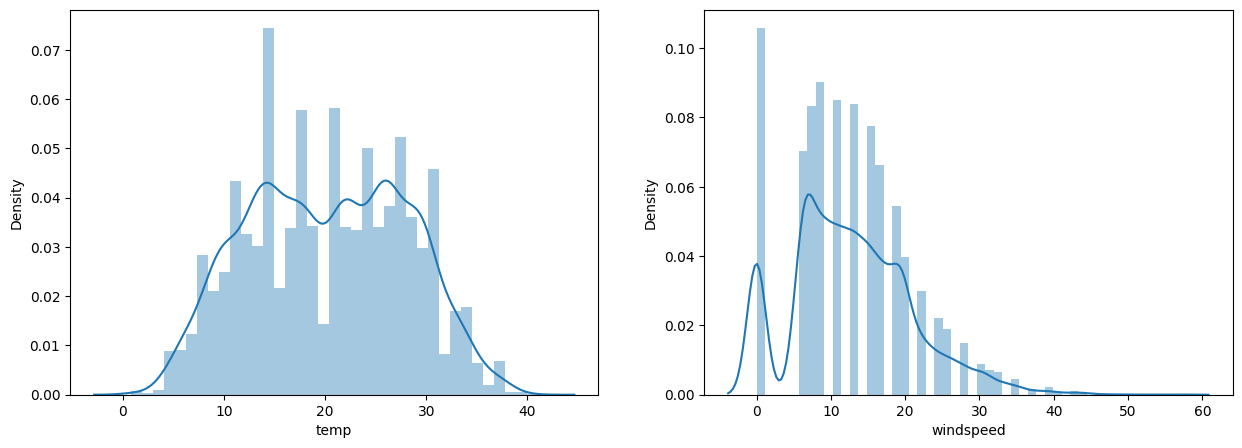

In [ ]:
features = ['temp', 'windspeed']
plt.subplots(figsize=(15, 5))
for i, col in enumerate(features):
  plt.subplot(1, 2, i + 1)
  sns.distplot(data[col])
plt.show()

Temperature values are normally distributed but due to the high number of 0 entries in the windspeed column, the data distribution shows some irregularities.

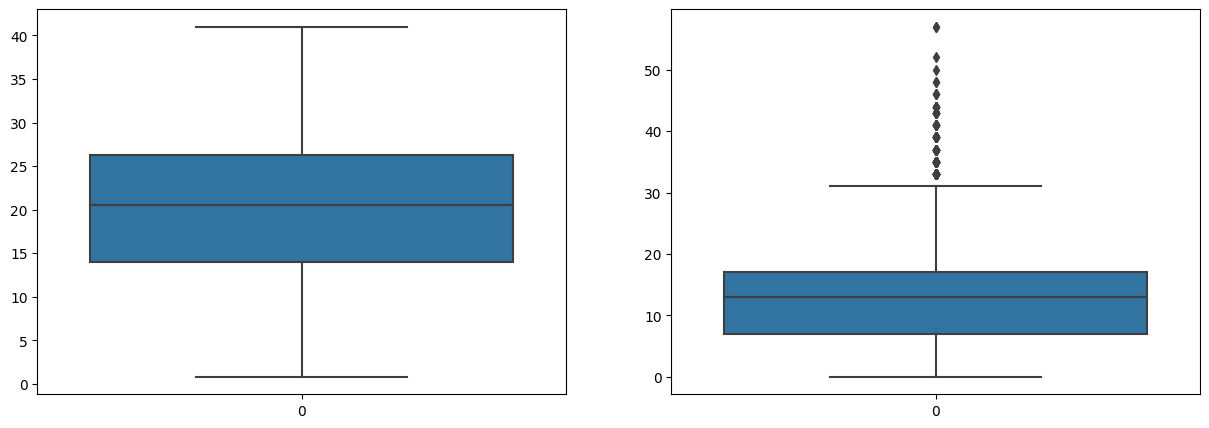

In [ ]:
#outliers
features = ['temp', 'windspeed']
plt.subplots(figsize=(15, 5))
for i, col in enumerate(features):
  plt.subplot(1, 2, i + 1)
  sns.boxplot(data[col])
plt.show()

In [ ]:
num_rows = data.shape[0] - data[data['windspeed']<32].shape[0]
print(f'Number of rows that will be lost if we remove outliers is equal to {num_rows}.')

Number of rows that will be lost if we remove outliers is equal to 227.


There are total 10000 rows so 227 rows won't affect the learning for model

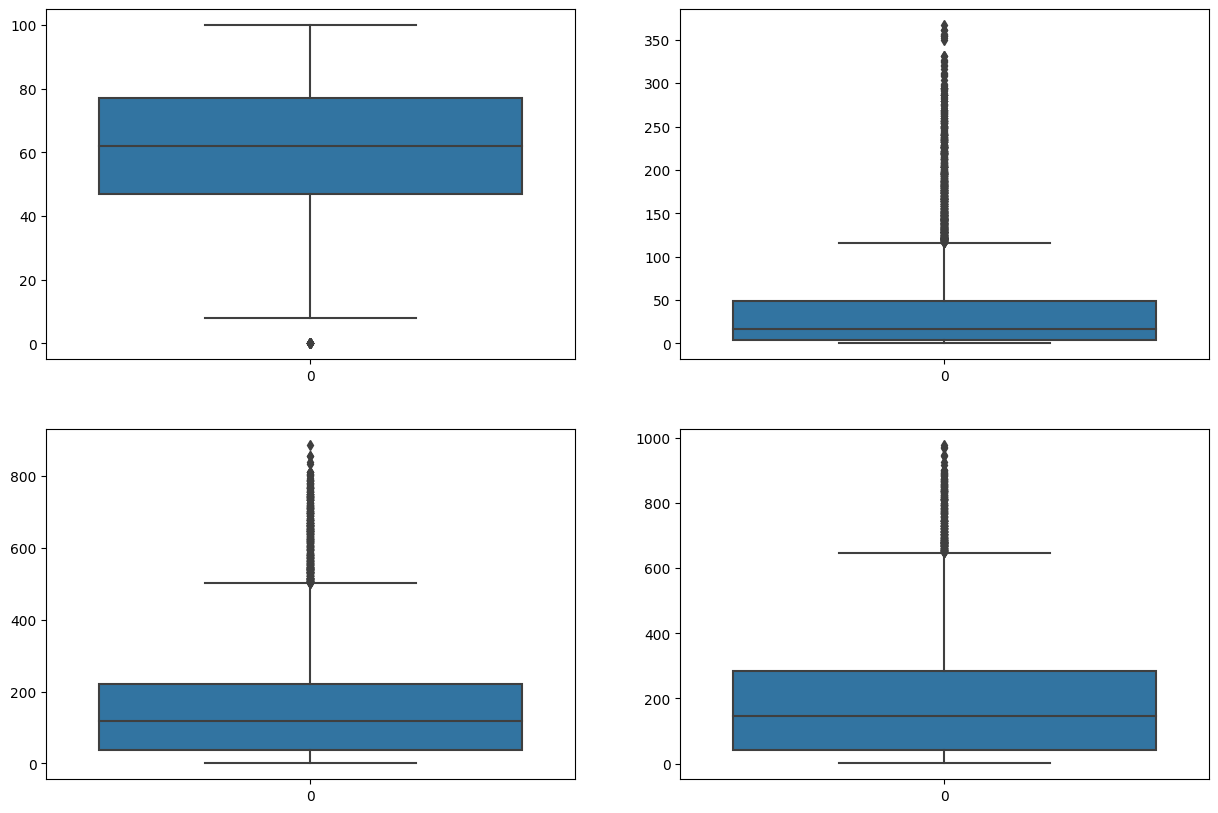

In [ ]:
features = ['humidity', 'casual', 'registered', 'count']
plt.subplots(figsize=(15, 10))
for i, col in enumerate(features):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data[col])
plt.show()

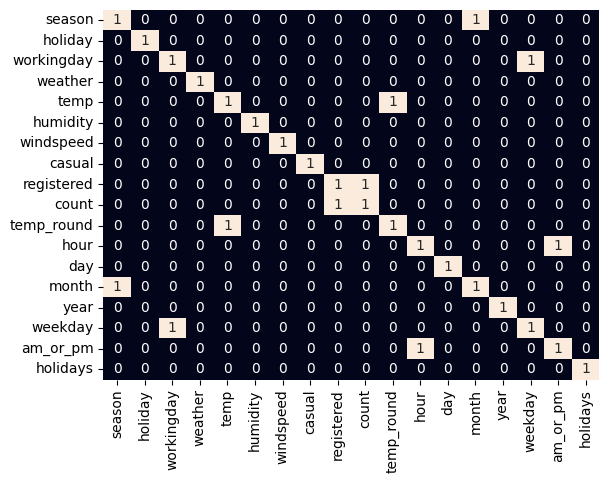

In [ ]:
#checking highly correlated data
sns.heatmap(data.corr() > 0.8,
           annot=True,
           cbar=False)
plt.show()

The 'registered' feature is strongly linked to the target variable ('count'), posing a risk of data leakage. To prevent this,  the 'registered' column and the 'time' feature is excluded from our set of features.

In [ ]:
#removing outliers found in from above observations humidity and windspeed
data.drop(['registered', 'hour'], axis=1, inplace=True)
data = data[(data['windspeed'] < 32) & (data['humidity'] > 0)]

In [ ]:
data.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,casual,count,temp_round,day,month,year,weekday,am_or_pm,holidays
0,1,0,0,1,9.84,81,0.0,3,16,8.0,1,1,2011,0,0,0
1,1,0,0,1,9.02,80,0.0,8,40,8.0,1,1,2011,0,0,0
2,1,0,0,1,9.02,80,0.0,5,32,8.0,1,1,2011,0,0,0
3,1,0,0,1,9.84,75,0.0,3,13,8.0,1,1,2011,0,0,0
4,1,0,0,1,9.84,75,0.0,0,1,8.0,1,1,2011,0,0,0


Model Training

In [ ]:
#splitting training and testing data
features = data.drop(['count'], axis=1)
target = data['count'].values

X_train, X_val, Y_train, Y_val = train_test_split(features,
                                                  target,
                                                  test_size = 0.1,
                                                  random_state=22)
X_train.shape, X_val.shape

((9574, 15), (1064, 15))

In [ ]:
#Normalizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
linear_model = LinearRegression()
cv_values = [5, 10, 15, 20]

for cv_value in cv_values:

    kf = KFold(n_splits=cv_value, shuffle=True, random_state=42)
    cross_val_scores = -cross_val_score(linear_model, X_train, Y_train, cv=kf, scoring='neg_mean_absolute_error')

    avg_mae = cross_val_scores.mean()

    print(f'Linear Regression (CV={cv_value}):')
    print('Average Training Error (MAE): ', avg_mae)
    print()
linear_model.fit(X_train, Y_train)

train_preds_linear = linear_model.predict(X_train)
val_preds_linear = linear_model.predict(X_val)

print('Final Training Error: ', mae(Y_train, train_preds_linear))
print('Final Validation Error: ', mae(Y_val, val_preds_linear))

Linear Regression (CV=5):
Average Training Error (MAE):  82.056669034853

Linear Regression (CV=10):
Average Training Error (MAE):  82.06962495917496

Linear Regression (CV=15):
Average Training Error (MAE):  82.02289512315399

Linear Regression (CV=20):
Average Training Error (MAE):  82.00619144005618

Final Training Error:  81.77627832748377
Final Validation Error:  82.03642556354018


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error



best_alpha = None
best_mse = float('inf')
alpha_values = [0.01, 0.1, 1, 10,25,50,75,100]
for alpha in alpha_values:
    ridge_reg = Ridge(alpha=alpha).fit(X_train, Y_train)
    mse = mean_squared_error(Y_val, ridge_reg.predict(X_val))

    if mse < best_mse:
        best_alpha, best_mse = alpha, mse

final_ridge_reg = Ridge(alpha=best_alpha).fit(X_train, Y_train)
final_mse = mean_squared_error(Y_val, final_ridge_reg.predict(X_val))

print(f"Best Alpha: {best_alpha}")
print(f"Final Ridge Regression MSE on Test Set: {final_mse}")

Best Alpha: 50
Final Ridge Regression MSE on Test Set: 13304.270117011036


In [ ]:
best_alpha = None
best_mse = float('inf')

for alpha in range(0,100):
    lasso_reg = Lasso(alpha=alpha).fit(X_train, Y_train)
    mse = mean_squared_error(Y_val, lasso_reg.predict(X_val))

    if mse < best_mse:
        best_alpha, best_mse = alpha, mse

final_lasso_reg = Lasso(alpha=best_alpha).fit(X_train, Y_train)
final_mse = mean_squared_error(Y_val, final_lasso_reg.predict(X_val))

print(f"Best Alpha: {best_alpha}")
print(f"Final Lasso Regression MSE on Test Set: {final_mse}")

Best Alpha: 1
Final Lasso Regression MSE on Test Set: 13304.641170489173


In [ ]:
from sklearn.model_selection import cross_val_score,KFold
n_estimators_values = [50, 100, 200]
cv_values = [5, 10, 15, 20]

best_mse = float('inf')
best_n_estimators = None
best_cv = None

for n_estimators in n_estimators_values:
    for cv_value in cv_values:
        random_forest = RandomForestRegressor(n_estimators=n_estimators, random_state=42)

        kf = KFold(n_splits=cv_value, shuffle=True, random_state=42)
        mse_values = -cross_val_score(random_forest, X_train, Y_train, cv=kf, scoring='neg_mean_squared_error')

        mean_mse = np.mean(mse_values)

        print(f"Mean Squared Error (n_estimators={n_estimators}, cv={cv_value}): {mean_mse}")

        if mean_mse < best_mse:
            best_mse = mean_mse
            best_n_estimators = n_estimators
            best_cv = cv_value

print(f"\nBest Model:")
print(f"  n_estimators: {best_n_estimators}")
print(f"  cv: {best_cv}")
print(f"  Best Mean Squared Error: {best_mse}")

Mean Squared Error (n_estimators=50, cv=5): 9044.620524366588
Mean Squared Error (n_estimators=50, cv=10): 9016.068977674968
Mean Squared Error (n_estimators=50, cv=15): 8963.502843703689
Mean Squared Error (n_estimators=50, cv=20): 8935.96699634098
Mean Squared Error (n_estimators=100, cv=5): 8960.341274319111
Mean Squared Error (n_estimators=100, cv=10): 8904.085160509701
Mean Squared Error (n_estimators=100, cv=15): 8865.93868146695
Mean Squared Error (n_estimators=100, cv=20): 8834.798742782279
Mean Squared Error (n_estimators=200, cv=5): 8903.822167865921


In [ ]:
results = {
    (50, 5): 9044.620524366588,
    (50, 10): 9016.068977674968,
    (50, 15): 8963.502843703689,
    (50, 20): 8935.96699634098,
    (100, 5): 8960.341274319111,
    (100, 10): 8904.085160509701,
    (100, 15): 8865.93868146695,
    (100, 20): 8834.798742782279,
    (200, 5): 8903.822167865921,
    (200, 10): 8852.648360886464,
    (200, 15): 8798.077889082237,
    (200, 20): 8790.248394947408
}

# Convert results to a DataFrame
df_results = pd.DataFrame(list(results.items()), columns=['Parameters', 'Mean Squared Error'])
df_results[['n_estimators', 'cv']] = pd.DataFrame(df_results['Parameters'].tolist(), index=df_results.index)
df_results.drop(columns=['Parameters'], inplace=True)

# Extract the best Mean Squared Error for each cv
best_per_cv = df_results.groupby('cv')['Mean Squared Error'].min().reset_index()

# Create a line plot
plt.plot(best_per_cv['cv'], best_per_cv['Mean Squared Error'], marker='o', color='orange', linestyle='-', linewidth=2)
plt.xlabel('Cross-validation (cv)')
plt.ylabel('Best Mean Squared Error')
plt.title('Best Mean Squared Error for Each Cross-validation (cv)')
plt.show()

# Print the best model information
print("\nBest Model:")
print(best_per_cv)

In [ ]:
from sklearn.metrics import accuracy_score
C_values = [0.1,0.2,0.3,0.5,0.7,1.0,1.5,2,2.5,5,7.5,10.0, 100.0]

for C_value in C_values:
    svm_classifier = SVC(kernel='linear', C=C_value)
    svm_classifier.fit(X_train, Y_train)
    svm_predictions = svm_classifier.predict(X_val)
    accuracy = accuracy_score(Y_val, svm_predictions)
    print(f"Accuracy (C={C_value}): {accuracy}")

BEST MODEL: C=10.0 Accuracy=0.02537593984962406

In [ ]:
C_values = [0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.5, 2, 2.5, 5, 7.5, 10.0, 100.0]
accuracies = [0.015037593984962405, 0.015037593984962405, 0.015037593984962405, 0.013157894736842105,
              0.017857142857142856, 0.017857142857142856, 0.016917293233082706, 0.015977443609022556,
              0.015977443609022556, 0.017857142857142856, 0.020676691729323307, 0.02537593984962406,
              0.023496240601503758]

# Create a line plot
plt.plot(C_values, accuracies, marker='o', linestyle='-', color='b')
plt.xscale('log')  # Use log scale for better visualization if C values are on a wide range
plt.xlabel('C values')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different C values in SVM')
plt.show()

In [ ]:
# Initialize lists to store results
n_estimators_values = [50, 100, 200]
cv_values = [5, 10, 15, 20]
train_errors = []
val_errors = []
mse_values = { 9044.620524366588, 9016.068977674968, 8963.502843703689, 8935.96699634098, 8960.341274319111, 8904.085160509701, 8865.93868146695, 8834.798742782279,8903.822167865921,8852.648360886464,8798.077889082237, 8790.248394947408}
mean_mse = np.mean(mse_values)
for n_estimators in n_estimators_values:
    for cv_value in cv_values:
        random_forest = RandomForestRegressor(n_estimators=n_estimators, random_state=42)

        kf = KFold(n_splits=cv_value, shuffle=True, random_state=42)
        mse_values = -cross_val_score(random_forest, X_train, Y_train, cv=kf, scoring='neg_mean_squared_error')

        mean_mse = np.mean(mse_values)

        # Calculate training error
        random_forest.fit(X_train, Y_train)
        train_preds = random_forest.predict(X_train)
        train_error = mean_squared_error(Y_train, train_preds)

        # Append errors to lists
        train_errors.append(train_error)
        val_errors.append(mean_mse)

# Convert errors to numpy arrays for easier manipulation
train_errors = np.array(train_errors)
val_errors = np.array(val_errors)

# Calculate bias and variance
bias_squared = (train_errors - val_errors) ** 2
variance = np.var(val_errors)

# Visualize bias and variance trade-off
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_errors)), bias_squared, label='Bias^2')
plt.plot(range(len(train_errors)), [variance] * len(train_errors), label='Variance')
plt.title('Bias-Variance Trade-off for Random Forest Model')
plt.xlabel('Model Complexity')
plt.ylabel('Error')
plt.legend()
plt.show()

TypeError: ignored

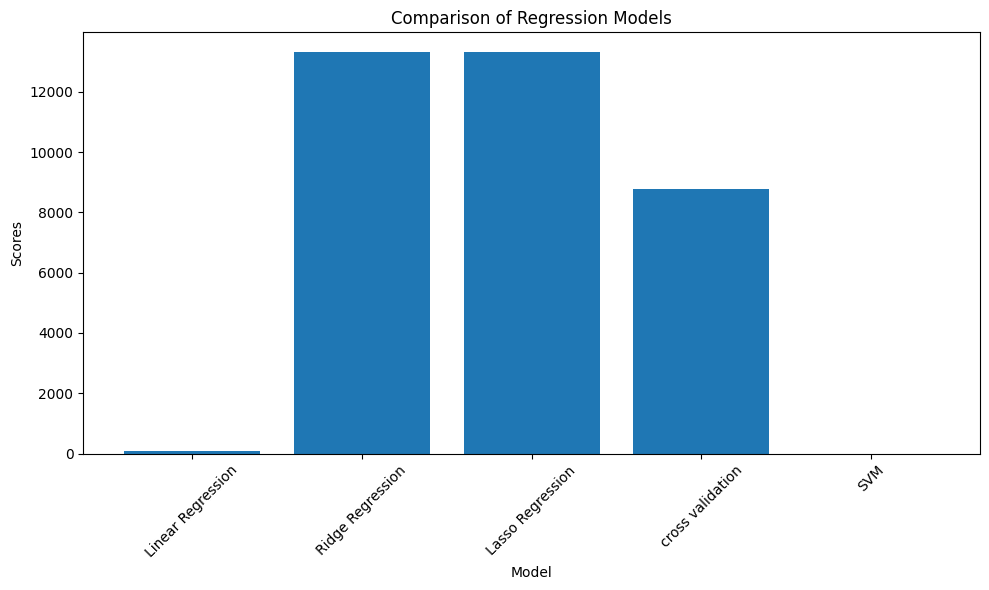

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

linear_regression_value = 81.97873232914674
ridge_regression_value = 13304.270117011038
lasso_regression_value = 13304.641170489173
cross_validation = 8790.248394947408
svm_value = 0.02537593984962406

models = ['Linear Regression', 'Ridge Regression', 'Lasso Regression','cross validation', 'SVM']

plt.figure(figsize=(10, 6))
plt.bar(models, [linear_regression_value, ridge_regression_value, lasso_regression_value, cross_validation, svm_value])
plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Comparison of Regression Models')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()